# Imports

In [1]:
import matplotlib.pyplot as plt 
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

# Constants

In [2]:
#TRAIN_PATH = "../../data/train/df_train_ID_"
#TEST_PATH = "../../data/test/df_test_ID_"
DATASET_PATH = "../../data/dataset/df_ID_"
MODELS =  "../../data/models/"
DATA_PATH =  "../../data/detection_fuite.csv" 
x = "valeur_active"
RANDOM_STATE = 42

# Read Data

In [3]:
ID = "5"
#X_train = pd.read_parquet(TRAIN_PATH+ID)
#X_test =  pd.read_parquet(TEST_PATH+ID)
X = pd.read_parquet(DATASET_PATH+ID)
X_scaled = pd.read_parquet(DATASET_PATH+ "5_scaled")
print("Data Loaded!")

Data Loaded!


In [4]:
X.head()

,valeur_active,rolling_mean,rolling_std,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,resid,seasonal,trend
valeur_date,,,,,,,,,,,,,,,,,,
2019-01-01,38.0,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.694650,-29.267634,67.962283
2019-01-02,38.0,NaN,NaN,1,2,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.671160,-29.262489,67.933649
2019-01-03,38.0,NaN,NaN,1,3,38.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.909543,-28.995466,67.905009
2019-01-04,38.0,NaN,NaN,1,4,38.0,38.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.821831,-29.054532,67.876363
2019-01-05,38.0,NaN,NaN,1,5,38.0,38.0,38.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.824293,-29.023419,67.847711


In [5]:
X_scaled.head()

,valeur_active,rolling_mean,rolling_std,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,resid,seasonal,trend
index,,,,,,,,,,,,,,,,,,
0,-0.247937,NaN,NaN,-1.601021,-0.999544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.224781,-0.501333,2.065029
1,-0.247937,NaN,NaN,-1.601021,-0.499544,-0.248035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.224343,-0.501242,2.062265
2,-0.247937,NaN,NaN,-1.601021,0.000456,-0.248035,-0.24814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.228794,-0.496556,2.059501
3,-0.247937,NaN,NaN,-1.601021,0.500456,-0.248035,-0.24814,-0.248238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.227156,-0.497593,2.056736
4,-0.247937,NaN,NaN,-1.601021,1.000456,-0.248035,-0.24814,-0.248238,-0.248336,NaN,NaN,NaN,NaN,NaN,NaN,-0.227202,-0.497047,2.053971


In [6]:
print("X Shape :", X.shape)
print("X_leakage Shape :", X_scaled.shape)

X Shape : (2192, 18)
X_leakage Shape : (2192, 18)


# Build model

In [7]:
features = ["valeur_active", "resid", "seasonal", "trend"]

In [66]:
# Visualization of the results
def plot(data, title=None, xlabel="Instance"):
    plt.figure(figsize=(10, 5))
    if "is_leakage" in data.columns: 
        normal = data[data['is_leakage'] == False]
        #plt.scatter(normal.index, normal['resid'], label='Normal')

        anomalies = data[data['is_leakage'] == True]
        #plt.scatter(anomalies.index, anomalies['resid'], label='Anomaly')
        plt.ylabel("Residuals")

    elif "is_noise" in data.columns:
        
        normal = data[data['is_noise'] != -1]
        #plt.scatter(normal.index, normal['resid'], label='Normal')

        anomalies = data[data['is_noise'] == -1]
        #plt.scatter(anomalies.index, anomalies['resid'], label='Anomaly')
        plt.ylabel("Residuals")
        
    elif "anomaly" in data.columns:
        # Plot normal instances
        #normal = data[data['anomaly'] == 1]
        normal = data[data['anomaly_score'] >= 0]
        #plt.scatter(normal.index, normal['anomaly_score'], label='Normal')
        
        # Plot anomalies
        anomalies = data[data['anomaly_score'] < 0]
        #plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')

        plt.ylabel("Anomaly score")
    
    plt.scatter(normal.index, normal['resid'], label='Normal')
    plt.scatter(anomalies.index, anomalies['resid'], label='Anomaly')


    plt.title(title)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

## Baseline 

**comment** : Our baseline model identifies all values outside the range between the 10th and 90th quantiles as leaks. 

In [9]:
def baseline_model(X):
    q_10 = X["resid"].quantile(0.1)
    q_90 = X["resid"].quantile(0.9)
    X["is_leakage"] = ~X["resid"].between(q_10, q_90)
    return X

In [10]:
X_pred_baseline = baseline_model(X)

In [11]:
X_pred_baseline["is_leakage"].value_counts()

is_leakage
False    1752
True      440
Name: count, dtype: int64

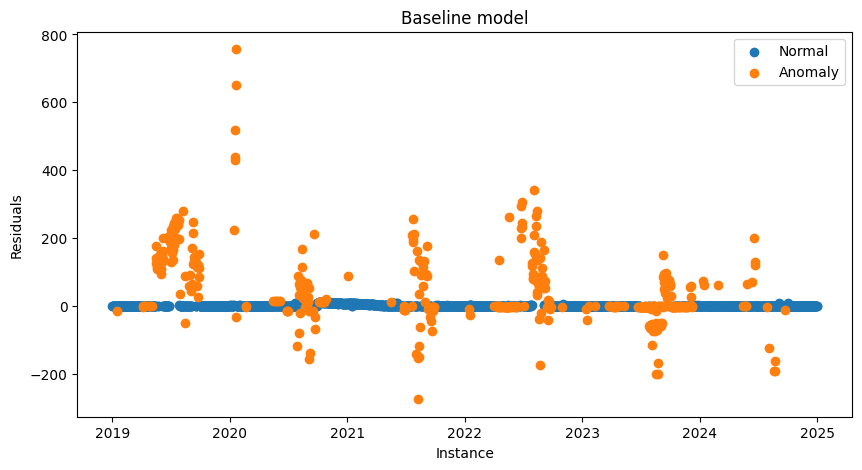

In [12]:
plot(X_pred_baseline, title="Baseline model")

## IsolationForest

### Default hyperparameters

In [13]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(X)
data = pd.DataFrame(np_scaled)

In [14]:
X_features = X[features]

In [15]:
n_estimators = 100  # Number of trees
contamination = "auto"  # Expected proportion of anomalies

In [16]:
# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=n_estimators,
                            contamination=contamination,
                            random_state=RANDOM_STATE)
iso_forest.fit(X_features)

,n_estimators,100
,max_samples,'auto'
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [17]:
# Calculate anomaly scores and classify anomalies
data = X_features.copy()
data['anomaly'] = iso_forest.predict(X_features)
data['anomaly_score'] = iso_forest.decision_function(X_features)

data['anomaly'].value_counts()

anomaly
 1    1847
-1     345
Name: count, dtype: int64

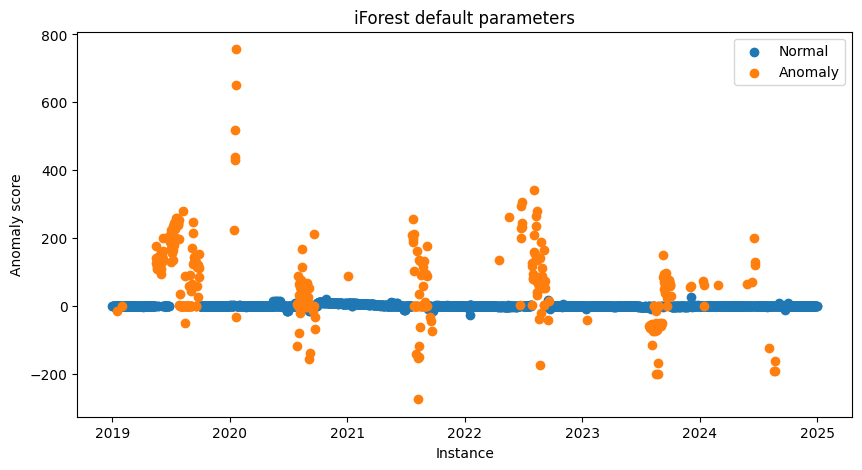

In [18]:
plot(data, title="iForest default parameters")

### Iterate

In [19]:
def train_iforest(n_estimators=100, contamination=0.075, X=X_features, 
          random_state=RANDOM_STATE, boostrap=True, max_samples=512,
                 title="iForest"):
    
    iso_forest = IsolationForest(n_estimators=n_estimators,
                                contamination=contamination,
                                random_state=random_state,
                                max_samples=max_samples,
                                bootstrap=boostrap)
    iso_forest.fit(X)

    data = X.copy()
    data['anomaly'] = iso_forest.predict(X)
    data['anomaly_score'] = iso_forest.decision_function(X)

    print(data['anomaly'].value_counts())

    plot(data, title=f"{title} with contamination {contamination}")
    return data

anomaly
 1    2027
-1     165
Name: count, dtype: int64


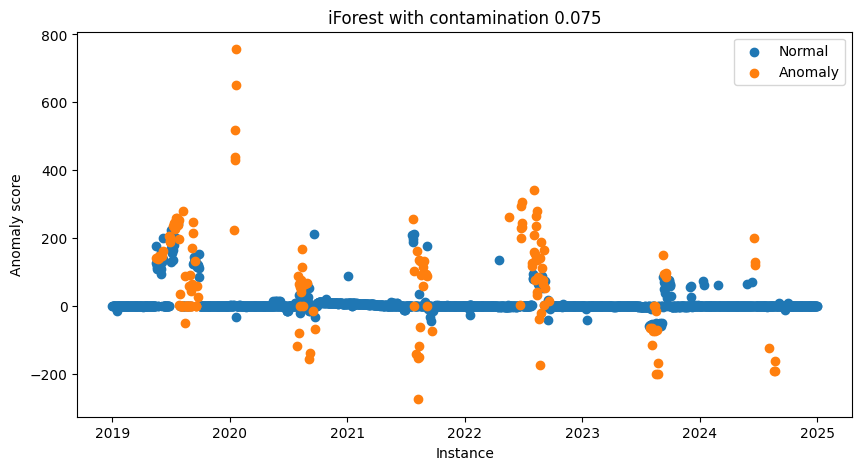

In [20]:
new_data = train_iforest()

### DBSCAN

In [67]:
from sklearn.cluster import DBSCAN

# Run DBSCAN

dbscan = DBSCAN(eps=20, min_samples=10)
dbscan.fit(X[features])


# Extract labels and core samples
labels = dbscan.labels_
data = X[features].copy()
outliers = X[labels == -1]
data["is_noise"] = labels

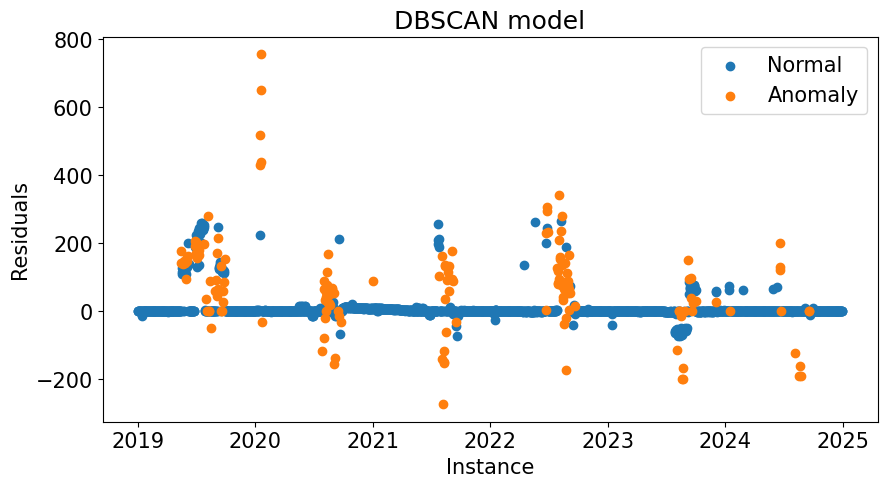

In [68]:
plot(data, title="DBSCAN model", xlabel="Instance")

## Evaluate

In [30]:
X_leaks_baseline = X_pred_baseline[X_pred_baseline["is_leakage"] == True]["resid"]
X_leaks_iforest = new_data[new_data["anomaly"] == -1]["resid"]
X_leaks_dbscan = outliers["resid"]

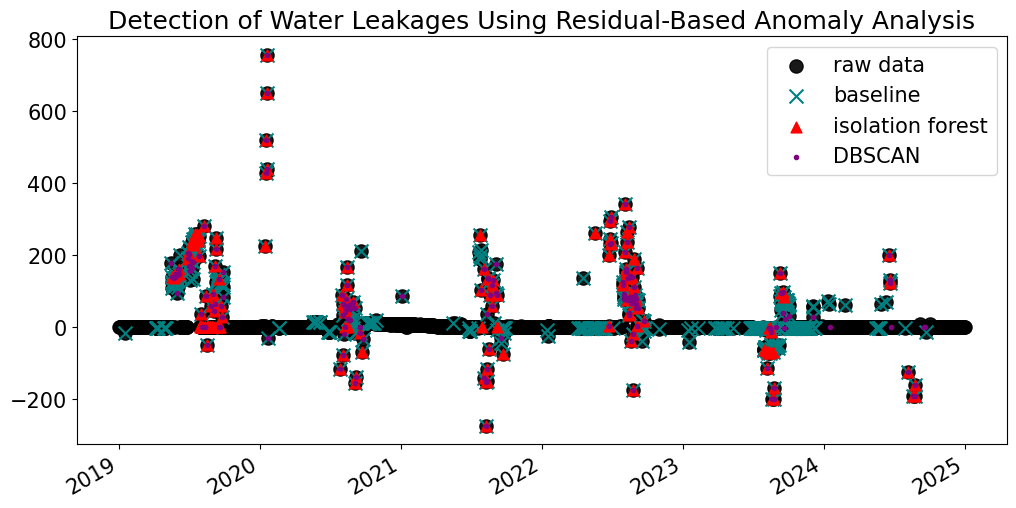

In [31]:
fig, ax = plt.subplots()

ax.scatter(X.index, X["resid"], color='black', marker="o", alpha=0.9, s=90, label="raw data")
ax.scatter(X_leaks_baseline.index, X_leaks_baseline.values,marker="x", s=100, color='teal', label="baseline")
ax.scatter(X_leaks_iforest.index, X_leaks_iforest.values, color='red', s=60, marker="^", label="isolation forest")
ax.scatter(X_leaks_dbscan.index, X_leaks_dbscan.values, color='purple', marker=".", label="DBSCAN")

plt.legend()
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
fig.autofmt_xdate()
plt.title("Detection of Water Leakages Using Residual-Based Anomaly Analysis")
plt.show()

### Interactive plot

In [33]:
pio.renderers.default = "browser"

fig = go.Figure()

# Raw data
fig.add_trace(go.Scatter(
    x=X.index,
    y=X["resid"],
    mode="markers",
    name="Raw data",
    marker=dict(
        color="black",
        size=30,
        opacity=0.8
    )
))

# Baseline
fig.add_trace(go.Scatter(
    x=X_leaks_baseline.index,
    y=X_leaks_baseline.values,
    mode="markers",
    name="Baseline",
    marker=dict(
        symbol="x",
        color="teal",
        size=15
    )
))

# Isolation Forest
fig.add_trace(go.Scatter(
    x=X_leaks_iforest.index,
    y=X_leaks_iforest.values,
    mode="markers",
    name="Isolation Forest",
    marker=dict(
        symbol="triangle-up",
        color="red",
        size=20
    )
))

# DBSCAN
fig.add_trace(go.Scatter(
    x=X_leaks_dbscan.index,
    y=X_leaks_dbscan.values,
    mode="markers",
    name="DBSCAN",
    marker=dict(
        symbol="cross",
        color="purple",
        size=7
    )
))

fig.update_layout(
    title="Residual-Based Detection of Water Leakages Over Time",
    xaxis_title="Date",
    yaxis_title="Residuals",
    template="plotly_white",
    height=500,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()